In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from glob import glob
import scipy.signal as signal
import cartopy.crs as ccrs
import cmaps
import cartopy.feature as cf
import cmocean


def filter_timeseries(ts, order, cutoff, btype='lowpass', fs=1, **kwargs):
    """Given an array, this function apply a butterworth (high/low pass) 
    filter of the given order and cutoff frequency.
    For example:
    If 'ts' is a timeseries of daily samples, filter_timeseries(ts,3,1/20)
    will return the series without the 20 days or less variability using an
    order 3 butterworth filter. 
    In the same way, filter_timeseries(ts,3,1/20, btype='highpass') will
    return the series with only the 20 days or less variability.

    Args:
        ts (array_like): timeseries or 1D array to filter
        order (int): _description_
        cutoff (array_like): Single float for lowpass or highpass filters, 
        arraylike for bandpass filters.
        btype (str, optional): Th type of filter. Defaults to 'lowpass'.
        fs (int): Sampling frequency. Defaults to 1
        **kwargs are passed to scipy.signal.filtfilt

    Returns:
        output (array): Filtered array
    """
    mask = np.isnan(ts)
    nans = np.ones(len(ts))*np.nan
    if mask.sum()==len(ts):
        return nans
    else:
        b, a = signal.butter(order, cutoff, btype=btype, fs=fs)
        filt=signal.filtfilt(b, a, ts[~mask], **kwargs)
        output=np.ones(len(ts))*np.nan
        output[np.where(~mask)] = filt
        return output
    
def filter_xarray(data, dim, order, cutoff, btype='lowpass', parallel=False, fs=1):
    """Given a 3d DataArray, with time and spatial coordinates, this function apply
    the 1D function filter_timeseries along the time dimension, filter the complete
    xarray data.

    Args:
        data (XDataArray): data
        dim (str): name of the time dimension
        order (int): butterworth filter order
        cutoff (array_like): if float, the cutoff frequency, if array must be the
                            [min,max] frequencys for the bandpass filter.
        btype (str, optional): {lowpass,highpass,bandpass}. Defaults to 'lowpass'.
        parallel (bool, optional): If parallelize with dask. Defaults to False.
        fs (int, optional): Sampling frequency. Defaults to 1.

    Returns:
        XDataArray: filtered data
    """
    if parallel:
        dask='parallelized'
    else:
        dask='forbidden'
    filt = xr.apply_ufunc(filter_timeseries, data, order, cutoff, btype, fs,
                          input_core_dims=[[dim],[],[],[],[]],
                          output_core_dims=[[dim]],
                          exclude_dims=set((dim,)),
                          keep_attrs=True,
                          vectorize=True, dask=dask)
    filt[dim] = data[dim]
    return filt



In [3]:
# load and build coastal mask
mask = xr.open_dataset('data/ERA5_MASKS.nc').coastmask_south

In [3]:
# load coastal winds and mask
def preprocess(ds, mask=mask):
    print(ds.time[0].values)
    ds = ds.sortby('latitude').sortby('longitude')
    ds = ds.sel(latitude=slice(-40,-5)).isel(longitude=slice(0,-3))
    ds = ds.resample({'time':'d'}).mean()
    ds = ds.where(mask).mean('longitude').load()
    ds['ws'] = np.hypot(ds.u10, ds.v10)
    return ds['ws']
coastwinds = xr.open_mfdataset('~/storage/ERA5/COQUIMBO_VIENTO/WIND_Y*.nc',
                               preprocess=preprocess)
coastwinds = coastwinds.sortby('time')

2000-01-01T00:00:00.000000000
2000-10-01T00:00:00.000000000
2000-11-01T00:00:00.000000000
2000-12-01T00:00:00.000000000
2000-02-01T00:00:00.000000000
2000-03-01T00:00:00.000000000
2000-04-01T00:00:00.000000000
2000-05-01T00:00:00.000000000
2000-06-01T00:00:00.000000000
2000-07-01T00:00:00.000000000
2000-08-01T00:00:00.000000000
2000-09-01T00:00:00.000000000
2001-01-01T00:00:00.000000000
2001-10-01T00:00:00.000000000
2001-11-01T00:00:00.000000000
2001-12-01T00:00:00.000000000
2001-02-01T00:00:00.000000000
2001-03-01T00:00:00.000000000
2001-04-01T00:00:00.000000000
2001-05-01T00:00:00.000000000
2001-06-01T00:00:00.000000000
2001-07-01T00:00:00.000000000
2001-08-01T00:00:00.000000000
2001-09-01T00:00:00.000000000
2002-01-01T00:00:00.000000000
2002-10-01T00:00:00.000000000
2002-11-01T00:00:00.000000000
2002-12-01T00:00:00.000000000
2002-02-01T00:00:00.000000000
2002-03-01T00:00:00.000000000
2002-04-01T00:00:00.000000000
2002-05-01T00:00:00.000000000
2002-06-01T00:00:00.000000000
2002-07-01

In [4]:
# load monthly winds 
def preprocess(ds):
    print(ds.time[0].values)
    ds = ds.sortby('latitude').sortby('longitude')
    ds = ds.resample({'time':'m'}).mean().load()
    ds['ws'] = np.hypot(ds.u10, ds.v10)
    return ds

mwinds = xr.open_mfdataset('~/storage/ERA5/COQUIMBO_VIENTO/WIND_Y*', preprocess=preprocess)
mwinds = mwinds.sortby('time')

2000-01-01T00:00:00.000000000
2000-10-01T00:00:00.000000000
2000-11-01T00:00:00.000000000
2000-12-01T00:00:00.000000000
2000-02-01T00:00:00.000000000
2000-03-01T00:00:00.000000000
2000-04-01T00:00:00.000000000
2000-05-01T00:00:00.000000000
2000-06-01T00:00:00.000000000
2000-07-01T00:00:00.000000000
2000-08-01T00:00:00.000000000
2000-09-01T00:00:00.000000000
2001-01-01T00:00:00.000000000
2001-10-01T00:00:00.000000000
2001-11-01T00:00:00.000000000
2001-12-01T00:00:00.000000000
2001-02-01T00:00:00.000000000
2001-03-01T00:00:00.000000000
2001-04-01T00:00:00.000000000
2001-05-01T00:00:00.000000000
2001-06-01T00:00:00.000000000
2001-07-01T00:00:00.000000000
2001-08-01T00:00:00.000000000
2001-09-01T00:00:00.000000000
2002-01-01T00:00:00.000000000
2002-10-01T00:00:00.000000000
2002-11-01T00:00:00.000000000
2002-12-01T00:00:00.000000000
2002-02-01T00:00:00.000000000
2002-03-01T00:00:00.000000000
2002-04-01T00:00:00.000000000
2002-05-01T00:00:00.000000000
2002-06-01T00:00:00.000000000
2002-07-01

In [5]:
def intraseasonal_baseline(data):
    # stime = data.time
    data = data.resample({'time':'m'}).mean()
    data.coords['time'] = data.time+pd.Timedelta(days=15)
    data = data.resample({'time':'d'}).interpolate(kind='cubic')
    # data = data.reindex({'time':'stime'})
    return data

In [6]:
baseline = intraseasonal_baseline(coastwinds)

Text(0, 0.5, 'Latitude (°)')

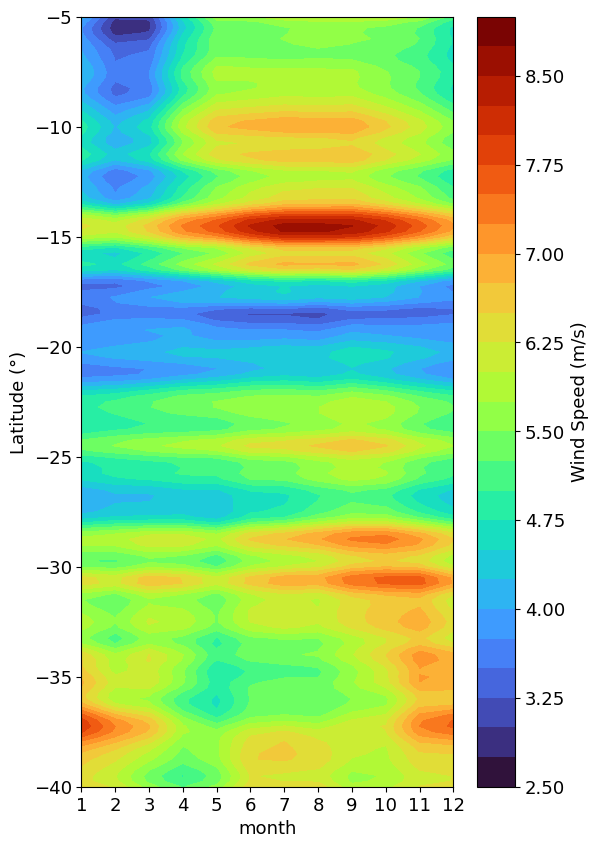

In [13]:

plt.figure(figsize=(6,10), facecolor='w', dpi=100)
plt.rc('font', size=13)
filter_xarray(coastwinds.groupby('time.month').mean().ws, 'latitude', 5, 1/5, btype='lowpass').plot.contourf(x='month', cmap='turbo', levels=np.arange(2.5,9+0.25, 0.25), cbar_kwargs={'label':'Wind Speed (m/s)'})
plt.xticks(np.arange(1,12+1));
plt.ylabel('Latitude (°)')

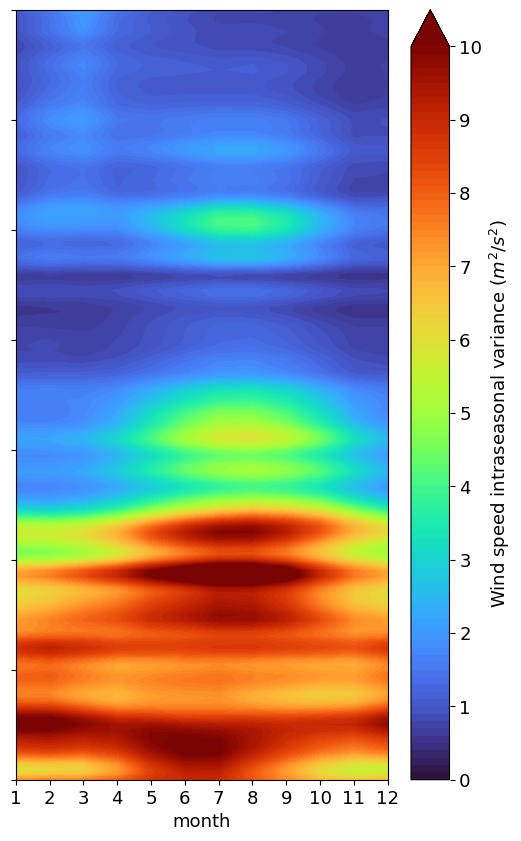

In [14]:
x = ((coastwinds-baseline).ws)
x = x.rolling({'time':90}, center=True).var()
x = x.dropna('time').groupby('time.month').mean()
x = filter_xarray(x, 'latitude', 5, 1/5, btype='lowpass')


plt.figure(figsize=(6,10), facecolor='w', dpi=100)
x.plot.contourf(x='month', levels=np.arange(0,10+0.1,0.1), cmap='turbo', cbar_kwargs={'label':'Wind speed intraseasonal variance ($m^2/s^2$)', 'ticks':np.arange(0,10+1,1)})
plt.xticks(np.arange(1,12+1));
plt.ylabel('')
plt.gca().set_yticklabels([]);

In [9]:
windanomaly = coastwinds.ws
windanomaly = windanomaly.sortby('latitude', ascending=False)
indexpaita    = windanomaly.sel(latitude=slice(-3,-6)).mean('latitude').rolling({'time':90}, center=True).var()
indexpisco    = windanomaly.sel(latitude=slice(-12,-16)).mean('latitude').rolling({'time':90}, center=True).var()
indexcoquimbo = windanomaly.sel(latitude=slice(-28,-32)).mean('latitude').rolling({'time':90}, center=True).var()

indexpaita = filter_xarray(indexpaita, 'time', 5, 1/180, btype='highpass')
indexpisco = filter_xarray(indexpisco, 'time', 5, 1/180, btype='highpass')
indexcoquimbo = filter_xarray(indexcoquimbo, 'time', 5, 1/180, btype='highpass')

In [10]:
kwindex = pd.read_csv('kw_index_glorys.csv', index_col=0, parse_dates=True).squeeze()

(-1.0, 1.0)

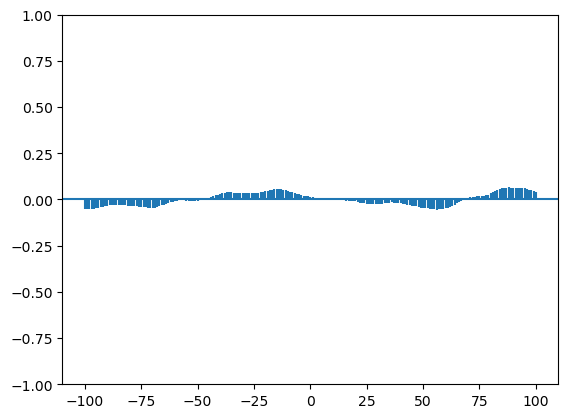

In [11]:
plt.xcorr(indexpisco.to_series().dropna().reindex(kwindex.index,method='nearest'),kwindex, maxlags=100)
plt.ylim(-1,1)

NameError: name 'mdates' is not defined

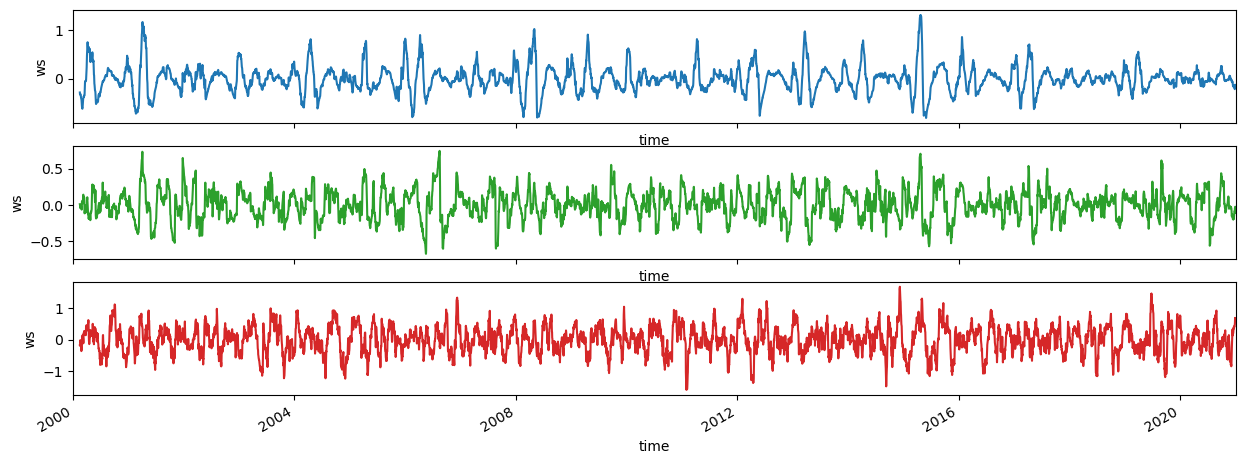

In [12]:
fig, ax = plt.subplots(3,1, sharex=True, sharey=False, dpi=100, facecolor='w', figsize=(15,5))

indexpaita.plot(ax=ax[0], color='tab:blue', label='Paita wind index')
indexpisco.plot(ax=ax[1], color='tab:green', label='Pisco wind index')
indexcoquimbo.plot(ax=ax[2], color='tab:red', label='Coquimbo wind index')

for axis in ax:
    axis.set_xlim(pd.to_datetime('2000'), pd.to_datetime('2021'))
    axis.xaxis.set_major_locator(mdates.YearLocator())
    axis.set_xlabel('')
    axis.set_ylabel('$m^2/s^2$')
    axis.legend(loc=(0,1))

---

In [ ]:
from sklearn.decomposition import PCA
# x = coastwinds.resample({'time':'m'}).mean()
# x.coords['time'] = x.time+pd.Timedelta(days=15)
# x = x.resample({'time':'d'}).interpolate(kind='cubic')
# x = (coastwinds-x).ws

x = filter_xarray(coastwinds.ws,'time',5,1/50,btype='highpass')*np.sqrt(np.cos(coastwinds.latitude*np.pi/180))
x = x.sel(latitude=slice(-18,0)).transpose('time','latitude')
pca = PCA(n_components=5, whiten=False).fit(x.data)
r2  = pca.explained_variance_ratio_
pc  = pd.DataFrame(pca.transform(x), index=x.time.values)

pc = [pc[i].to_xarray() for i in range(5)]
pc = -xr.concat(pc, 'comp').rename({'index':'time'})
corr = xr.corr(pc,coastwinds.ws,'time')

pcperu  = pc.copy()
corrperu = corr.copy()
r2peru = r2.copy()


# x = coastwinds.resample({'time':'m'}).mean()
# x.coords['time'] = x.time+pd.Timedelta(days=15)
# x = x.resample({'time':'d'}).interpolate(kind='cubic')
# x = coastwinds-x
x = filter_xarray(coastwinds.ws,'time',5,1/50,btype='highpass')*np.sqrt(np.cos(coastwinds.latitude*np.pi/180))
x = x.sel(latitude=slice(-40,-18)).transpose('time','latitude')
pca = PCA(n_components=5, whiten=False).fit(x.data)
r2  = pca.explained_variance_ratio_
pc  = pd.DataFrame(pca.transform(x), index=x.time.values)

pc = [pc[i].to_xarray() for i in range(5)]
pc = xr.concat(pc, 'comp').rename({'index':'time'})
corr = xr.corr(pc,coastwinds.ws,'time')
pcchile = pc.copy()
corrchile = corr.copy()
r2chile = r2.copy()


# x = coastwinds.resample({'time':'m'}).mean()
# x.coords['time'] = x.time+pd.Timedelta(days=15)
# x = x.resample({'time':'d'}).interpolate(kind='cubic')
# x = (coastwinds-x).ws
# x = x.sel(latitude=slice(-18,0))
x = filter_xarray(coastwinds.ws,'time',5,1/50,btype='highpass').transpose('time','latitude')*np.sqrt(np.cos(coastwinds.latitude*np.pi/180))
pca = PCA(n_components=5, whiten=False).fit(x.data)
r2  = pca.explained_variance_ratio_
pc  = pd.DataFrame(pca.transform(x), index=x.time.values)

pc = [pc[i].to_xarray() for i in range(5)]
pc = xr.concat(pc, 'comp').rename({'index':'time'})
corr = xr.corr(pc,coastwinds.ws,'time')


# x = filter_xarray(tropical_glorys.zos,'time',5,1/180,btype='highpass').swap_dims({'index':'distance'})
# x = filter_xarray(x,'distance',5,1/100).swap_dims({'distance':'index'})


# y = filter_xarray(south_reforecast.isel(leadtime=0).rename({'inittime':'time'}).zos,'time',5,1/180,btype='highpass').swap_dims({'index':'distance'})
# y = filter_xarray(y.drop_duplicates('distance'),'distance',5,1/10).swap_dims({'distance':'index'})
# pca_nrt = PCA(n_components=3, whiten=False).fit(y.data)
# r2_nrt  = pca_nrt.explained_variance_ratio_
# pc_nrt  = pd.DataFrame(pca_nrt.transform(y), index=y.time.values)


/home/lucas/miniconda3/envs/main/lib/python3.8/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


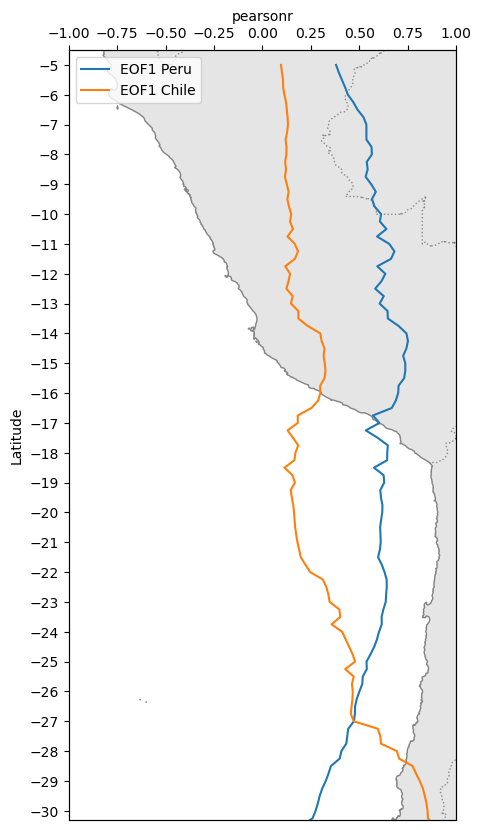

In [ ]:
fig,ax = plt.subplots(1,1, dpi=100, facecolor='w', subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(5,10))

ax.coastlines('10m', alpha=0.4)
ax.add_feature(cf.LAND, color='silver', alpha=0.4)
ax.add_feature(cf.BORDERS, color='k', ls=":", alpha=0.4)

nax = ax.twiny()
# corr.isel(comp=0).plot(y='latitude', ax=nax, lw=2, label='EOF1')
# corr.isel(comp=1).plot(y='latitude', ax=nax, lw=2, label='EOF2')
# corr.isel(comp=2).plot(y='latitude', ax=nax, lw=2, label='EOF3')
# corr.isel(comp=3).plot(y='latitude', ax=nax, lw=2)
corrperu.isel(comp=0).plot(y='latitude',ax=nax, label='EOF1 Peru')
corrchile.isel(comp=0).plot(y='latitude',ax=nax, label='EOF1 Chile')
# corrperu.isel(comp=1).plot(y='latitude',ax=nax, label='EOF2 Peru')
# corrperu.isel(comp=2).plot(y='latitude',ax=nax, label='EOF3 Peru')
# corrchile.isel(comp=0).plot(y='latitude', ax=nax, label='EOF1 Chile')

# corrperu.isel(comp=1).plot(y='latitude',ax=nax, label='EOF2 Peru')
# corrchile.isel(comp=1).plot(y='latitude', ax=nax, label='EOF2 Chile')


ax.set_extent([-92,-60,-29.5,-4.5])
ax.set_yticks(np.arange(-30,-5+1,1));
nax.set_xlim(-1,1)
nax.set_xlabel('pearsonr')
ax.set_ylabel('Latitude')
nax.legend()

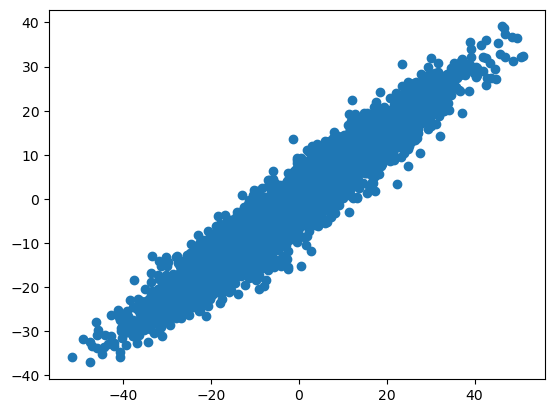

In [ ]:
plt.scatter((pcperu[0]+pcchile[0]),pc[0])

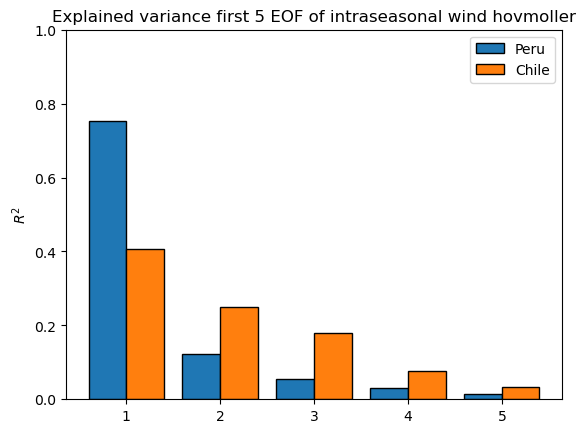

In [ ]:
plt.bar(np.arange(1,1+len(r2))-0.2, r2peru, edgecolor='k', width=0.4, label='Peru')
# plt.stem(np.arange(1,1+len(r2)), np.cumsum(r2))
plt.bar(np.arange(1,1+len(r2chile))+0.2, r2chile, edgecolor='k', width=0.4, label='Chile')
plt.ylim(0,1)
# plt.xticks(np.arange(1,len(r2)))
plt.ylabel('$R^2$')
plt.title('Explained variance first 5 EOF of intraseasonal wind hovmoller')
plt.legend()

In [ ]:

# wind_index = pc.isel(comp=0).to_series()-pc.isel(comp=1).to_series()
# wind_index = (wind_index-wind_index.mean())/wind_index.std()

# wind_index = ((pcchile[0].where(pcchile[0]>=0)**2+pcperu[0].where(pcperu[0]>=0)**2)**0.5).to_series()#.fillna(0)
wind_index = pc[0]
wind_index = wind_index.to_series()

# wind_index = (pc[0]+pc[1]-pc[2]).to_series()
indexes = pd.concat([pcchile[0].to_series().rename('pc1_chile'),pcperu[0].to_series().rename('pc1_peru'), wind_index.rename('windindex')], axis=1)
indexes.to_csv('coastalwind_index.csv')

<AxesSubplot:xlabel='time'>

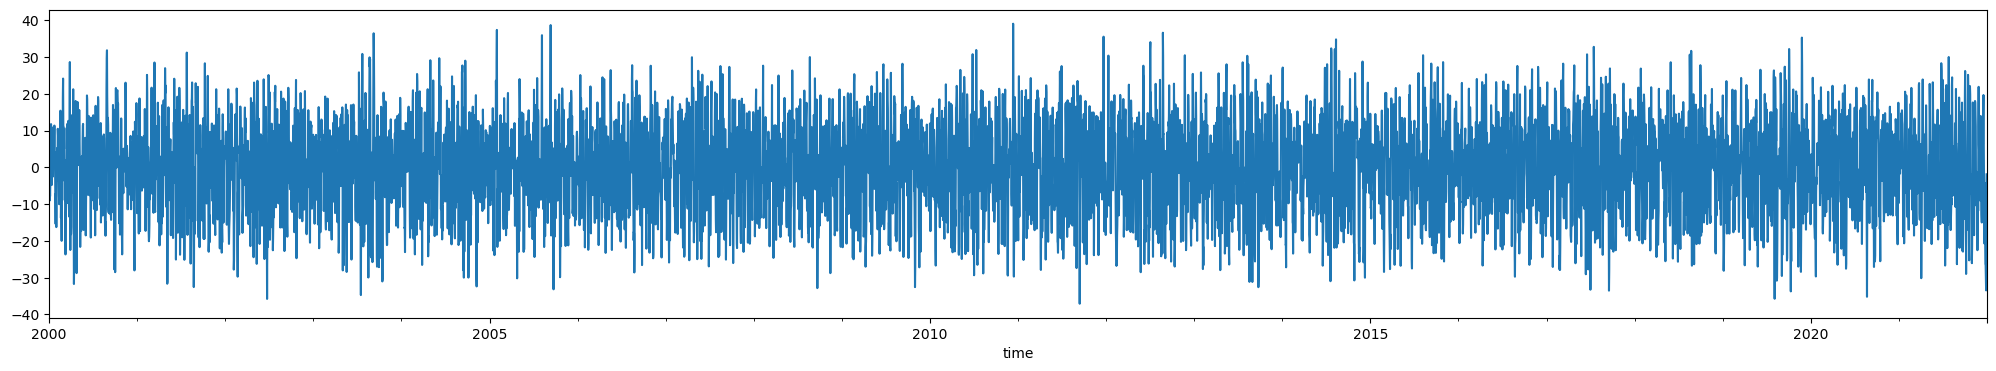

In [ ]:
wind_index.plot(figsize=(25,4))

In [ ]:
wind_index.quantile(0.75),wind_index.quantile(0.25)

(8.805774357405173, -8.641533495468583)

<AxesSubplot:xlabel='time'>

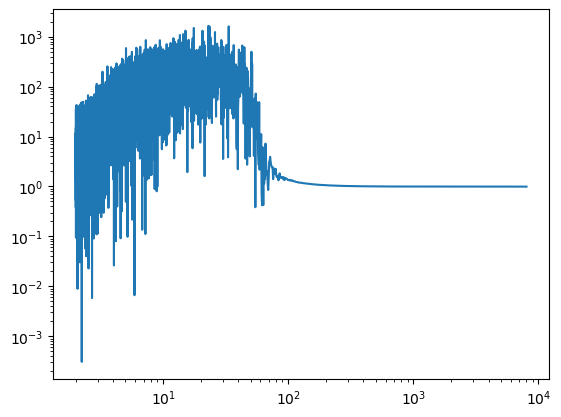

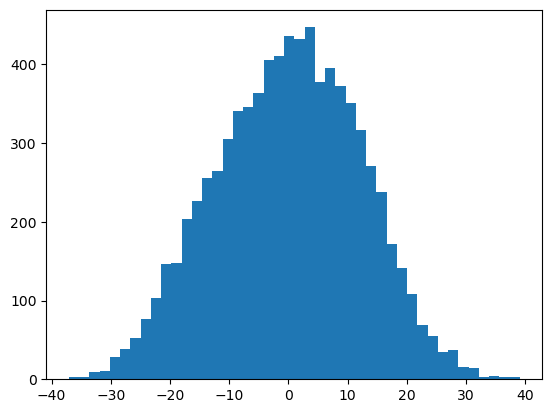

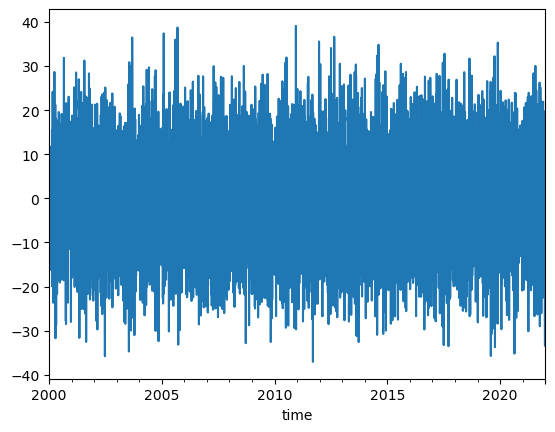

In [ ]:
from scipy.signal import periodogram
plt.figure()
f,s = periodogram(pcperu[0].dropna('time'))
plt.loglog(1/f[1:],s[1:]);

plt.figure()
plt.hist(wind_index, bins='auto')

plt.figure()
wind_index.plot()

(10907.0, 19042.0)

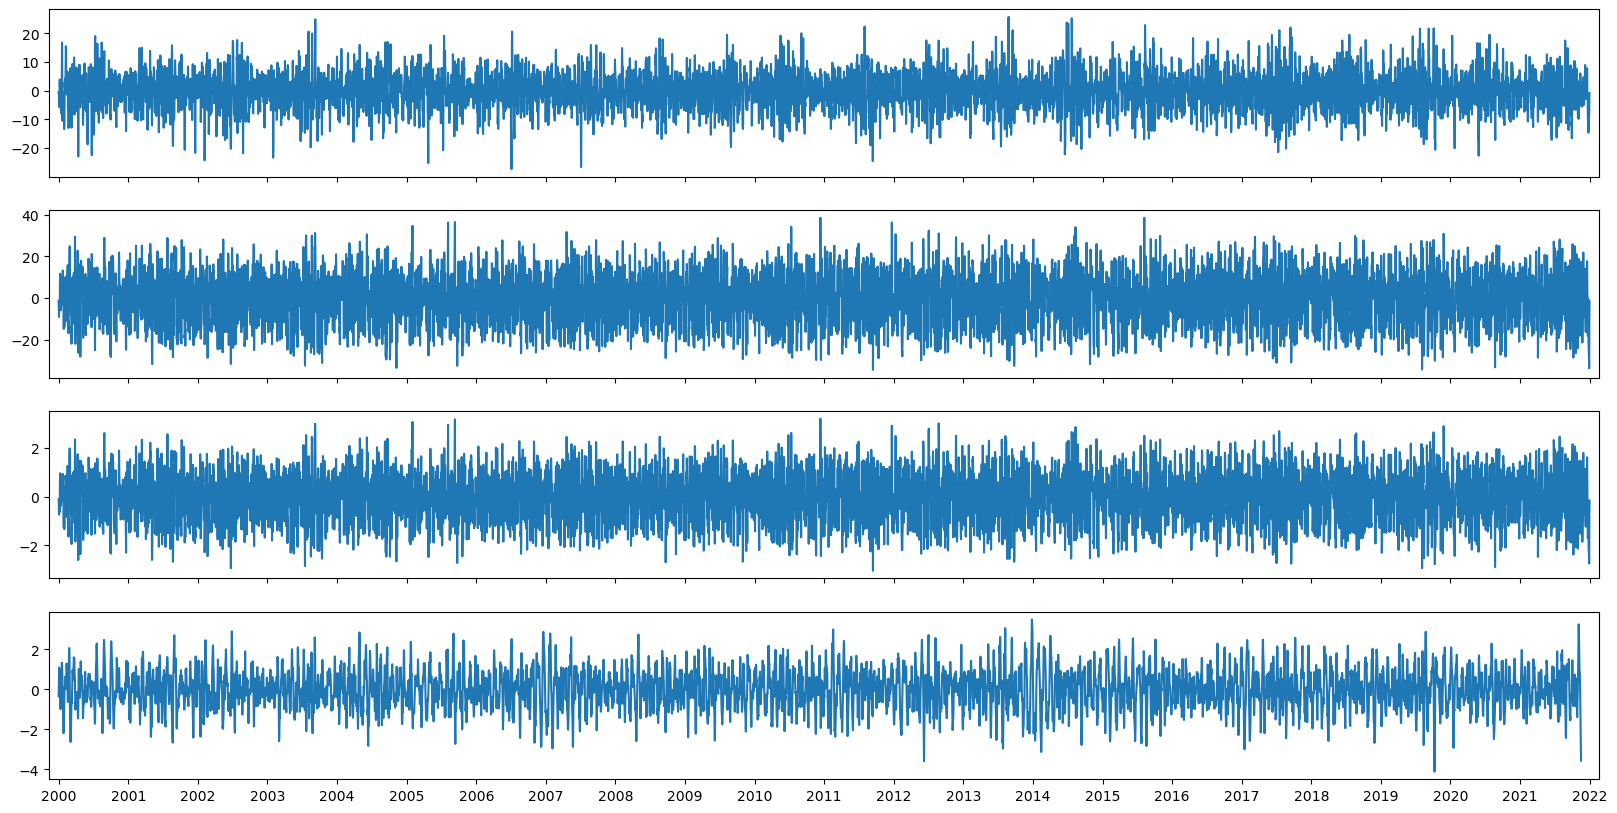

In [ ]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(4,1, sharex=True, figsize=(20,10), dpi=100, facecolor='w')


ax[1].plot(pcchile[0].time, pcchile[0])
# ax[0].plot(pcchile[0].time, filter_timeseries(pcchile[0], 5, 1/30))
ax[0].plot(pcperu[0].time, pcperu[0])
x = wind_index
x = (x-x.mean())/x.std()
ax[2].plot(wind_index.index, x)
y = (wind_index[::-1].rolling(46).mean()[::-1])
y = (y-y.mean())/y.std()
ax[3].plot(wind_index.index,y)
# plt.figure(figsize=(25,3))

# plt.plot(x.index,(x-x.mean())/x.std())
# # ((x-x.mean())/x.std()).plot()
# y = (wind_index[::-1].rolling(46).mean()[::-1]).dropna()
# # ((y-y.mean())/y.std()).plot()
# plt.plot(y.index,(y-y.mean())/y.std())


# ax = plt.gca()
ax[0].xaxis.set_major_locator(mdates.YearLocator())
ax[0].set_xlim(wind_index.index[0]-pd.Timedelta(days=50), pd.Timedelta(days=50)+wind_index.index[-1])
# ax[0].set_xticklabels(pd.date_range('2000','2021',freq='y'))
# pcchile[0].plot()
# pcperu[0].plot()





/tmp/ipykernel_32297/3386402274.py:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(1/f, s)
/tmp/ipykernel_32297/3386402274.py:5: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(1/f, s)
/tmp/ipykernel_32297/3386402274.py:8: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(1/f, s)


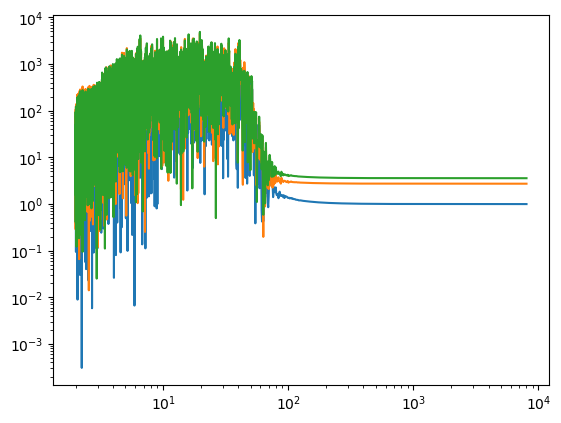

In [ ]:
f,s = periodogram(pcperu[0])
plt.loglog(1/f, s)

f,s = periodogram(pcchile[0])
plt.loglog(1/f, s)

f,s = periodogram(wind_index)
plt.loglog(1/f, s)



<AxesSubplot:xlabel='time'>

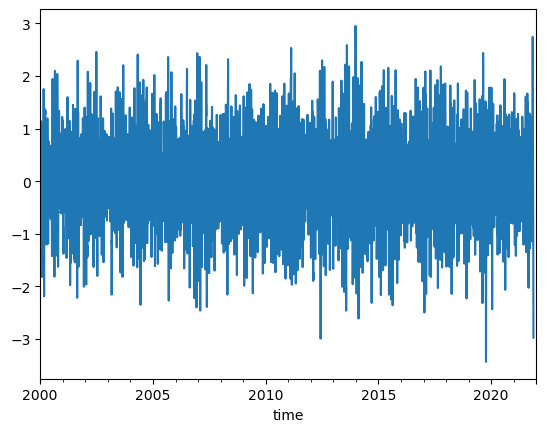

In [ ]:
(wind_index[::-1].rolling(46).mean()[::-1]).plot()